In [7]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from autoencoder import NonLinearAutoencoder
from solver import train_vali_all_epochs, nl_dev_train_vali_all_epochs, test
from model_utils import load_model

import act_max_util as amu

In [9]:
steps = 100               # perform 100 iterations
unit = 0                  # flamingo class of Imagenet
alpha = torch.tensor(100) # learning rate (step size)
verbose = False           # print activation every step
L2_Decay = True           # enable L2 decay regularizer
Gaussian_Blur = False     # enable Gaussian regularizer
Norm_Crop = False         # enable norm regularizer
Contrib_Crop = False      # enable contribution regularizer

In [50]:
sae = load_model('/home/david/mnist_model/sae/0/', 'sae', 59)
dae = load_model('/home/david/mnist_model/dae/0/', 'dae', 59)

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_ep

In [48]:
all_sae_rfs = np.load('Saved_Results/sae_rf_all.npy')
all_dae_rfs = np.load('Saved_Results/dae_rf_all.npy')

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_ep

(32,)


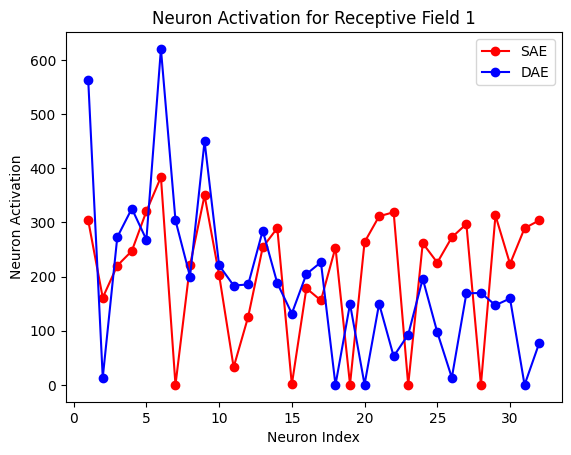

In [74]:
with torch.no_grad():
    for i in range(1):
        sae_average_activation = np.zeros((40, 32))
        dae_average_activation = np.zeros((40, 32))
        for j in range(40):
            sae = load_model(f'/home/david/mnist_model/sae/{i}/', 'sae', 59)
            dae = load_model(f'/home/david/mnist_model/dae/{i}/', 'dae', 59)
            sae_rf = all_sae_rfs[j][i].reshape(-1)
            dae_rf = all_dae_rfs[j][i].reshape(-1)
            
            input = torch.tensor(sae_rf).to('cpu')
            sae_encoded, _ = sae(input)
            input = torch.tensor(dae_rf).to('cpu')
            dae_encoded, _ = dae(input)

            sae_average_activation[j] = sae_encoded.cpu().numpy()
            dae_average_activation[j] = dae_encoded.cpu().numpy()

        sae_encoded = np.mean(sae_average_activation, axis=0)
        print(sae_encoded.shape)
        dae_encoded = np.mean(dae_average_activation, axis=0)
    
        plt.figure()
        plt.plot(range(1, len(sae_encoded)+1), sae_encoded, marker='o', color='red')
        plt.plot(range(1, len(dae_encoded)+1), dae_encoded, marker='o', color='blue')
        plt.xlabel('Neuron Index')
        plt.ylabel('Neuron Activation')
        plt.legend(['SAE', 'DAE'])
        plt.title(f'Neuron Activation for Receptive Field {i+1}')
        plt.show()

In [84]:
from tqdm import tqdm
sae_rf_matrices = []

for iteration in range(3):    

    data = torch.randn(28, 28)
    data = data.unsqueeze(0)
    input = data.view(data.size(0), -1)
    input.requires_grad_(True)

    sae = load_model(f'/home/david/mnist_model/sae/{iteration}', 'sae', 59)
    
    layer_name = 'bottle_neck'
    sae_activation_dictionary = {}

    sae.encoder.encoder_3.register_forward_hook(amu.layer_hook(sae_activation_dictionary, layer_name))

    sae_rf_ls = []
    for i in range(32):
        output = amu.act_max(network=sae,
                        input=input,
                        layer_activation=sae_activation_dictionary,
                        layer_name=layer_name,
                        unit=i,
                        steps=steps,
                        alpha=alpha,
                        verbose=verbose,
                        L2_Decay=L2_Decay,
                        Gaussian_Blur=Gaussian_Blur,
                        Norm_Crop=Norm_Crop,
                        Contrib_Crop=Contrib_Crop,
                        )
        sae_rf_ls.append(output.detach().numpy())
    sae_rf_ls = np.array(sae_rf_ls).squeeze()


    sae_rf_matrices.append(sae_rf_ls)

In [86]:
np.array(sae_rf_matrices).shape

(3, 32, 784)